In [44]:
# Import the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.compat import lzip

# An example with simulated data

In [62]:
# Generate some sample data
np.random.seed(0)
n_obs = 100
data = np.random.normal(size=(n_obs, 2))
data += np.arange(n_obs)[:, np.newaxis]

Pandas DataFrame is a widely-used data structure in Python for handling structured data, such as time series data commonly used in VAR modeling. Its intuitive interface, labeling and indexing capabilities, rich functionality, and seamless integration with other libraries make it the preferred choice for data manipulation and VAR estimation in Python.

In [63]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['X1', 'X2'])

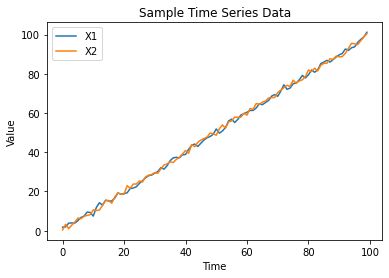

In [64]:
# Plot the time series data
df.plot()
plt.title('Sample Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In Python, fitting a VAR model involves using the VAR class from the statsmodels library. This module provides comprehensive functionality for time series analysis, including VAR modeling. With statsmodels, we can easily specify the order of the VAR model, which determines the number of lagged observations included in the model. This flexibility allows us to tailor the model complexity to the characteristics of the time series data and the underlying system dynamics.

In [65]:
adfuller(df['X1'])[1]

0.9941657275847339

In [66]:
df['dX1'] = df['X1'] -  df["X1"].shift(1)
df['dX2'] = df['X2'] -  df["X2"].shift(1)
df = df[1:] #eliminate NaN

In [70]:
adfuller(df['dX1'])

(-8.357729339498562,
 2.878705776525002e-13,
 4,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 247.65394031411506)

In [71]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
        values 0, 1, ..., maxlag.
    
        * If "AIC" (default)

In [73]:
df

,X1,X2,dX1,dX2
1,1.978738,3.240893,0.214686,2.840736
2,3.867558,1.022722,1.888820,-2.218171
3,3.950088,2.848643,0.082530,1.825921
4,3.896781,4.410599,-0.053307,1.561956
5,5.144044,6.454274,1.247262,2.043675
...,...,...,...,...
95,93.707143,95.267051,0.446706,-0.275964
96,95.960717,94.831907,2.253574,-0.435144
97,97.523277,96.828454,1.562559,1.996547
98,98.771791,98.823504,1.248514,1.995050


In [76]:
X = df.loc[:,["dX1","dX2"]].copy() # we only want dX1 and dX2
# df.loc: Access a group of rows and columns by label(s)
X

,dX1,dX2
1,0.214686,2.840736
2,1.888820,-2.218171
3,0.082530,1.825921
4,-0.053307,1.561956
5,1.247262,2.043675
...,...,...
95,0.446706,-0.275964
96,2.253574,-0.435144
97,1.562559,1.996547
98,1.248514,1.995050


In [77]:
# Fit VAR model
model = VAR(X)
order = 4  # Order of VAR model
results = model.fit(order)

# Print summary of the model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Feb, 2024
Time:                     08:37:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.891520
Nobs:                     95.0000    HQIC:                  0.603156
Log likelihood:          -270.961    FPE:                    1.50496
AIC:                     0.407627    Det(Omega_mle):         1.25576
--------------------------------------------------------------------
Results for equation dX1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          3.030040         0.542375            5.587           0.000
L1.dX1        -0.525980         0.105346           -4.993           0.000
L1.dX2         0.061463         0.101769            0.604           0.546
L2.dX1        -0

## Practical Example

The seminal paper titled "The Dynamic Effects of Aggregate Demand and Supply Disturbances," published in the American Economic Review in 1989, Blanchard and Quah propose a methodology to decompose fluctuations in output and prices into components attributable to aggregate demand (AD) and aggregate supply (AS) disturbances. They argue that understanding the relative contributions of demand and supply shocks to economic fluctuations is essential for policymakers to formulate effective stabilization policies.

Blanchard and Quah use a vector autoregressive (VAR) framework to analyze the dynamics of output and prices in the United States. The dataset they employ consists of quarterly observations spanning the period from 1953 to 1986.

In [87]:
'''
Downloading and preparing data using DataReader
'''
           
#Sample selection
start = '1948Q1'                                              
end = '1987Q3'

#Data from FRED
gdp = DataReader('GNPC96', 'fred', start=start,  end=end) # quarterly frequency
urate = DataReader('UNRATE', 'fred', start=start, end=end)  # monthly frequency

In [88]:
#Frequency change for urate
urateq = urate.resample('Q').mean() # Convenience method for frequency conversion and resampling of time series. 
                                    # Object must have a datetime-like index 
# urateq_test = urate.groupby(pd.PeriodIndex(urate.index, freq='Q'), axis=0).mean()

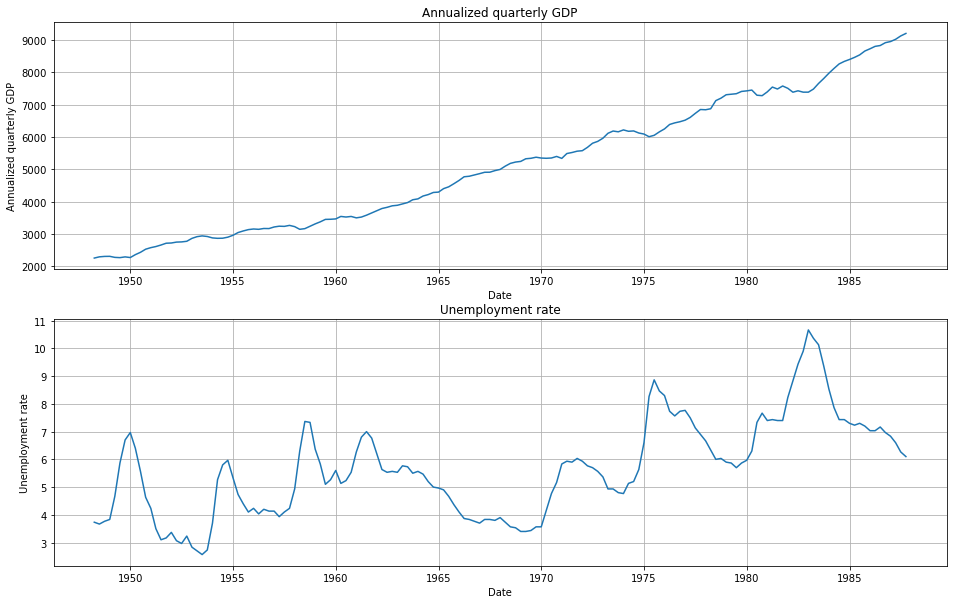

In [101]:
'''
Plot original data
'''

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(gdp)
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP')
plt.title('Annualized quarterly GDP')
plt.grid()
plt.subplot(212)
plt.plot(urateq)
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('Unemployment rate')
plt.grid()
plt.show()

In [90]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
        values 0, 1, ..., maxlag.
    
        * If "AIC" (default)

In [98]:
# Check stationarity of series
from statsmodels.tsa.stattools import adfuller

# Assuming 'data' is your time series data
result_1 = adfuller(urateq, regression='ct')

# Extracting test statistics and p-value
adf_statistic = result_1[0]
p_value = result_1[1]

# Printing test results
print('urateq:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

# Assuming 'data' is your time series data
result_2 = adfuller(gdp)

# Extracting test statistics and p-value
adf_statistic = result_2[0]
p_value = result_2[1]

# Printing test results
print('gdp:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

urateq:
ADF Statistic: -2.379583651816758
p-value: 0.39052768099433177
gdp:
ADF Statistic: 1.8241666832764825
p-value: 0.998395762517703


In [99]:
#From YYYYQ format to date format (find it important for matplotlib)
gdp.index = pd.date_range(start,'1987Q4',freq="Q")
urateq.index = pd.date_range(start,'1987Q4',freq="Q")

'''
Transforming the data part 2
'''


#create Data Frame
df = pd.concat((urateq, gdp), axis=1)
df.columns = ["urate","gdp"]


# Differenciate GDP and urate
df["lngdp"] = np.log(df["gdp"])
df["dy"] = (df["lngdp"] - df["lngdp"].shift(1))*400 #annualized quarterly GDP growth
df["durates"] = (df["urate"] - df["urate"].shift(1))
df = df[1:] # drop first observation


# Detrending as in the paper: Important to make the data covariance stationary. 
# Weak stationarity is an important property for representation and estimation
# Productivity Slowdown less apparent than in origal data, upward trend in urate present
# signal.detrend: Remove linear trend along axis from data.

df.loc[:"1973Q2","dys"] = signal.detrend(df.loc[:"1973Q2","dy"],type="constant")
df.loc["1973Q3":,"dys"] = signal.detrend(df.loc["1973Q3":,"dy"],type="constant")
df["urates"] = signal.detrend(df["urate"])

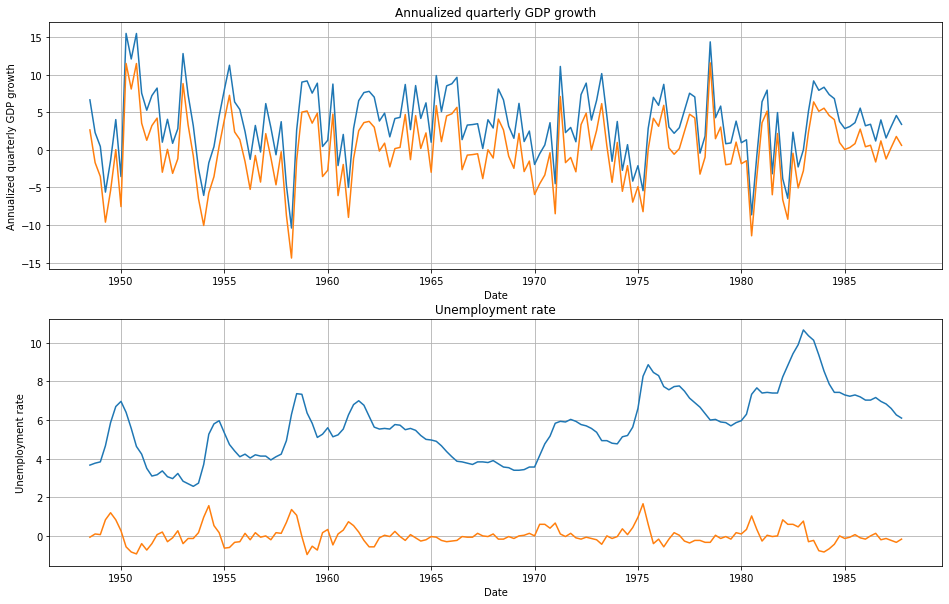

In [100]:
'''
Plot new data
'''

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(df['dy'],label='observed')
plt.plot(df['dys'],label='detrended')
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('Annualized quarterly GDP growth')
plt.grid()
plt.subplot(212)
plt.plot(df['urate'],label='observed')
plt.plot(df['durates'],label='detrended')
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('Unemployment rate')
plt.grid()
plt.show()

In [102]:
#Setting up the data for VAR
X = df.loc[:,["dys","durates"]].copy()
type(X)

pandas.core.frame.DataFrame

Python is an object oriented programming language. In Python, the dynamic nature of typing means we must be cautious about the type of objects we work with. Objects can change type during runtime, leading to unexpected behavior if operations are not appropriate for the object's type. Being mindful of object types helps prevent errors and ensures code reliability

In [103]:
model = VAR(X)
model.select_order(12, trend='n').summary()

,AIC,BIC,FPE,HQIC
0,0.4222,0.4222,1.525,0.4222
1,-0.1181,-0.03631*,0.8887,-0.08484
2,-0.1988,-0.03536,0.8197,-0.1324*
3,-0.2150*,0.03018,0.8066*,-0.1154
4,-0.1893,0.1377,0.8277,-0.05644
5,-0.1503,0.2585,0.8609,0.01581
6,-0.1522,0.3382,0.8594,0.04706
7,-0.1096,0.4626,0.8972,0.1229
8,-0.09753,0.5564,0.9087,0.1682
9,-0.08049,0.6552,0.9250,0.2184


In [104]:
model = VAR(X)
results = model.fit(3, trend='n')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Feb, 2024
Time:                     08:49:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.136324
Nobs:                     155.000    HQIC:               -0.00359260
Log likelihood:          -420.175    FPE:                   0.905545
AIC:                   -0.0992961    Det(Omega_mle):        0.839308
--------------------------------------------------------------------
Results for equation dys
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.dys             0.082186         0.111721            0.736           0.462
L1.durates        -4.213621         1.409532           -2.989           0.003
L2.dys             0.171330         0.117187            1.462           0.

In [106]:
# Stability Condition: roots are larger than one in absolute value.
results = model.fit(3, trend='n')
roots = results.roots
all_stable = all(np.abs(root) > 1 for root in roots)
if all_stable:
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

The VAR model is stable.


The ML estimator of the VAR parameters is equivalent to equation by equation OLS estimators.

We can write the model in a bigger one and use OLS which is equivalent to Maximum Likelihood for an unrestricted VAR
$$X = X_L\hat{B} + EPS$$
where $X$ is $T\times n$,$X_L$ is $T\times (n\times p)$ and $\hat{B}$ is $(n\times p) \times n$

$\hat{B}$ = $[\hat{B}(1)...\hat{B}(p)]$

Sometimes it is written as as $$X'=\hat{B}'X_L'+EPS'$$

In [118]:
'''
VAR with a OLS
'''
XLAG = pd.DataFrame() #empty Dataframe

num_lags = 3
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)
    
#change names to frames that we modify    
X2 = X.iloc[num_lags:,:]
XLAG2 = XLAG.iloc[num_lags:,:]
num_vars = X2.shape[1]
num_obs = X2.shape[0]

The resulting ML estimator of the VAR model parameters is:
\begin{equation}
    \hat{B} = \bigg[\sum^T_{t=1} x_t x^´_t \bigg]^{-1}\bigg[\sum^T_{t=1} y_t x^´_t \bigg]
\end{equation}

In matrix form:

\begin{equation}
    \hat{B} = (X^´X)^{-1} X^\prime Y
\end{equation}

In [119]:
# But what is this?
type(X2)

pandas.core.frame.DataFrame

We want to invert and use algebra, so we need to transform this into arrays: $\textbf{numpy package}$

In [120]:
#changing to arrays 
X3 = np.array(X2)
XLAG3 = np.array(XLAG2)

In [121]:
#VAR - standard OLS
Bhat = inv(XLAG3.T@XLAG3)@XLAG3.T@X3

In [133]:
(results.coefs)

array([[[ 0.08218595, -4.21362131],
        [-0.03385338,  0.36021834]],

       [[ 0.17133029,  2.93679032],
        [-0.03574939, -0.35322194]],

       [[-0.0144375 ,  1.27871604],
        [-0.01876582, -0.20254968]]])

In [130]:
Bhat

array([[ 0.08218595, -0.03385338],
       [-4.21362131,  0.36021834],
       [ 0.17133029, -0.03574939],
       [ 2.93679032, -0.35322194],
       [-0.0144375 , -0.01876582],
       [ 1.27871604, -0.20254968]])

# Curse of Dimensionality

In [79]:
# Generate sample data with 5 variables
np.random.seed(0)
n_obs = 100
n_variables = 5  # Number of variables
data = np.random.normal(size=(n_obs, n_variables))
data += np.arange(n_obs)[:, np.newaxis]

# Create a DataFrame
df = pd.DataFrame(data, columns=['X1', 'X2', 'X3', 'X4', 'X5'])

df['dX1'] = df['X1'] -  df["X1"].shift(1)
df['dX2'] = df['X2'] -  df["X2"].shift(1)
df['dX3'] = df['X3'] -  df["X3"].shift(1)
df['dX4'] = df['X4'] -  df["X4"].shift(1)
df['dX5'] = df['X5'] -  df["X5"].shift(1)
df = df[1:] #eliminate NaN

X = df.loc[:,["dX1","dX2","dX3","dX4","dX5"]].copy()

# Fit VAR model
model = VAR(X)
order = 4  # Order of VAR model
results = model.fit(order)

# Print summary of the model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Feb, 2024
Time:                     08:39:33
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    4.62553
Nobs:                     95.0000    HQIC:                   2.94341
Log likelihood:          -654.630    FPE:                    6.29607
AIC:                      1.80283    Det(Omega_mle):         2.31952
--------------------------------------------------------------------
Results for equation dX1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          1.890404         0.907272            2.084           0.037
L1.dX1        -0.854525         0.112110           -7.622           0.000
L1.dX2        -0.029397         0.118141           -0.249           0.803
L1.dX3         0

All standard errors are bigger, indicating a less efficient estimation. In the VAR model with more variables, the standard errors tend to increase relative to the VAR model with fewer variables. This increase in standard errors indicates a higher level of uncertainty in the parameter estimates due to the larger number of parameters being estimated simultaneously.